# Imports / Config

In [1]:
from collections import Counter
from datetime import datetime
from operator import itemgetter
import os
import pprint
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from content_corpus import ContentCorpus

pp = pprint.PrettyPrinter()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 14.1 µs


In [3]:
%%time
# recent_content_corpus.load_recent_content(df=pd.read_csv('recent_content_corpus.csv', index_col=0),
#                                           days_of_recent_content=2)
# recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
recent_content_corpus.load_recent_content(days_of_recent_content=2)

CPU times: user 1min 15s, sys: 2.86 s, total: 1min 18s
Wall time: 2min 35s


In [4]:
recent_content_corpus.df.to_csv('recent_content_corpus.csv')

In [5]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 24.2 s, sys: 969 ms, total: 25.1 s
Wall time: 25.5 s


In [6]:
%%time
recent_content_corpus.classify_content()


 svm classifier performance
 accuracy:   0.804
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.77      0.85      0.81       133
            Finance & Business       0.85      0.85      0.85       224
                Gear & Gadgets       0.67      0.62      0.64        13
            Lifestyle & Health       0.75      0.54      0.63        76
  Politics, Policy & Economics       0.80      0.90      0.85       133
Technology, Science & Medicine       0.75      0.77      0.75       149
                 Travel & Food       0.50      0.09      0.15        11
                   U.S. Sports       0.92      0.87      0.89        53
                  World Sports       0.93      0.93      0.93        29

                   avg / total       0.80      0.80      0.80       821

 confusion matrix: 
[[113   4   2   3   6   2   0   3   0]
 [  3 190   1   5  11  14   0   0   0]
 [  0   1   8   0   0   4   0   0 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))



 svm classifier performance
 accuracy:   0.854
 classification report: 
                      precision    recall  f1-score   support

          Asia & ANZ       0.86      0.90      0.88       233
              Europe       0.84      0.77      0.80        66
       Latin America       1.00      0.40      0.57         5
Middle East & Africa       0.98      0.87      0.92        47
       U.S. & Canada       0.82      0.83      0.82       149

         avg / total       0.86      0.85      0.85       500

 confusion matrix: 
[[209   3   0   1  20]
 [  9  51   0   0   6]
 [  1   0   2   0   2]
 [  2   4   0  41   0]
 [ 22   3   0   0 124]]
CPU times: user 1.88 s, sys: 159 ms, total: 2.04 s
Wall time: 1.67 s


# Story Clustering

## Cluster formation

In [7]:
from scipy.cluster.hierarchy import linkage as agglomerative_cluster

import configs
from utils import clean, gen_clusters, lemmatize, simple_split, vectorize

In [8]:
topic = (
    'Politics, Policy & Economics'
#     'Finance & Business'
#     'Technology, Science & Medicine'
#     'Sports'
#     'Entertainment & Arts'
)
region = (
    'U.S. & Canada'
#     'Latin America'
#     'Europe'
#     'Middle East & Africa'
#     'Asia & ANZ'
)
MIN_WORDS = 100
filt = (
    (recent_content_corpus.df['topic_classification_predicted'] == topic)
    & (recent_content_corpus.df['topic_classification_probability'] > 0.5)
    & (recent_content_corpus.df['region_classification_predicted'] == region)
    & (recent_content_corpus.df['region_classification_probability'] > 0.5)
    & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
)
df_subset = recent_content_corpus.df[filt].reset_index().drop(['index'], axis=1)
n_articles = len(df_subset)
print(n_articles)

6334


In [9]:
df_subset = df_subset.sample(min(n_articles, 2000)).reset_index()
n_articles = len(df_subset)

In [10]:
%%time
WORDS_TO_CONSIDER = 100
docs = list(df_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:WORDS_TO_CONSIDER])))

CPU times: user 224 ms, sys: 4.95 ms, total: 229 ms
Wall time: 231 ms


In [11]:
%%time
# replace w/ recent_content_corpus_objcect
doc_vectors, doc_idx_2_token = vectorize(docs, tfidf=True)
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}
doc_vectors

CPU times: user 633 ms, sys: 24.6 ms, total: 658 ms
Wall time: 663 ms


In [12]:
%%time
docs_ac_result = agglomerative_cluster(
    doc_vectors.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)
docs_ac_result_dec = docs_ac_result[::-1] # easier to work with

CPU times: user 1min, sys: 728 ms, total: 1min 1s
Wall time: 1min 2s


In [13]:
docs_ac_result_dec.shape

(1999, 4)

## Keyword recall / precision - proof of concept

In [14]:
keywords = ['shutdown', 'mueller', 'pompeo', 'desantis', 'tlaib', 'gabbard']

n_clusters = []
keywords_recalls = {}

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    n_clusters.append(n)
    for keyword in keywords:
        idx = doc_token_2_idx[keyword]
        df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

        cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)
        recall = max_support / total_support

        if keyword in keywords_recalls:
            keywords_recalls[keyword].append(recall)
        else:
            keywords_recalls[keyword] = [recall]    

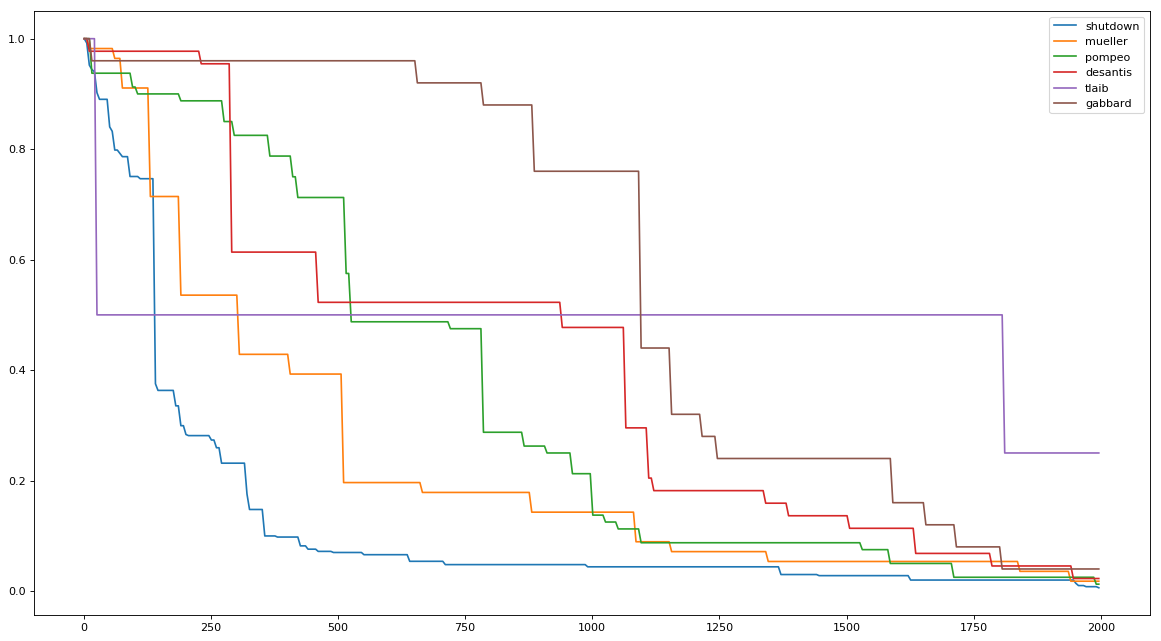

In [15]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
for keyword in keywords:
    plt.plot(n_clusters, keywords_recalls[keyword], label=keyword) 
plt.legend()
plt.show()

In [16]:
n_clusters = []
avg_recalls = []
avg_precisions = []

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    keyword_cluster_supports = {}
    for keyword in keywords:
        idx = doc_token_2_idx[keyword]
        df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

        cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
        max_cluster = cluster_supports.index[0]
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)

        cluster_supports = {cluster:support 
                            for cluster, support 
                            in zip(cluster_supports.index, cluster_supports.values)}
        cluster_supports['max_cluster'] = max_cluster
        cluster_supports['max_support'] = max_support
        cluster_supports['total_support'] = total_support

        keyword_cluster_supports[keyword] = cluster_supports

    recalls = []
    precisions = []
    for keyword in keywords:
        cluster_supports = keyword_cluster_supports[keyword]
        max_cluster = cluster_supports['max_cluster']
        max_support = cluster_supports['max_support']
        total_support = cluster_supports['total_support']

        recall = max_support / total_support
        recalls.append(recall)

        max_cluster_other_kw_articles = np.sum(
            [other_cluster_supports[max_cluster] 
            for other_keyword, other_cluster_supports 
            in keyword_cluster_supports.items()
            if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
        )
        precision = max_support / (max_support + max_cluster_other_kw_articles)
        precisions.append(precision)
        
    n_clusters.append(n)
    avg_recalls.append(np.mean(recalls))
    avg_precisions.append(np.mean(precisions))
    

In [17]:
n_clusters = np.array(n_clusters)
avg_recalls = np.array(avg_recalls)
avg_precisions = np.array(avg_precisions)

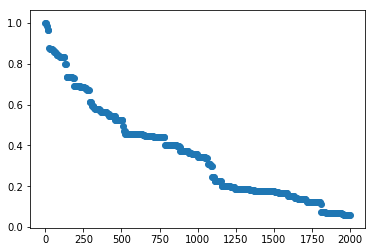

In [18]:
plt.scatter(n_clusters, avg_recalls)
plt.show()

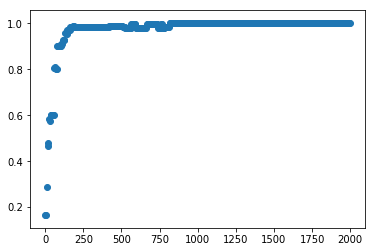

In [19]:
plt.scatter(n_clusters, avg_precisions)
plt.show()

In [20]:
avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)

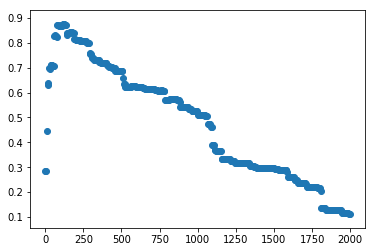

In [21]:
plt.scatter(n_clusters, avg_f1s)
plt.show()

## With LDA as keywords

Bottom line: 
- here, optimal selection is dependent on number of topics input to LDA and not very interpretable.
- it will be better to come up with a method for story keyword selection such that keywords obviously and consistently represent what we'd like to be separated by story clustering

In [22]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.5
)

In [23]:
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [24]:
doc_vectors

<2000x27242 sparse matrix of type '<class 'numpy.int64'>'
	with 555976 stored elements in Compressed Sparse Row format>

In [47]:
lda_model = LatentDirichletAllocation(
    n_components = 250,
    learning_method='batch',
    n_jobs=-1
)

In [48]:
%%time
lda_vectors = lda_model.fit_transform(doc_vectors)

CPU times: user 23.9 s, sys: 1min 26s, total: 1min 50s
Wall time: 2min 48s


In [49]:
topic_word_dists = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]

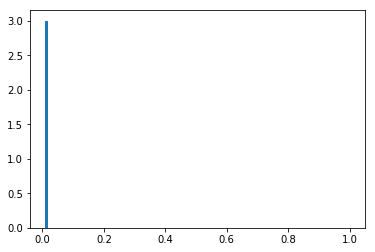

In [50]:
plt.hist(topic_word_dists[0], bins=np.arange(0.01, 1.01, 0.01))
plt.show()

In [51]:
topic_keywords = [itemgetter(*row)(doc_idx_2_token) for row in np.argsort(-topic_word_dists, axis=1)[:, :5]]

In [52]:
topic_keywords

[('democratic', 'committee', 'run', 'gabbard', 'house'),
 ('economic', 'world', 'shutdown', 'trade', 'forum'),
 ('pelosi', 'meeting', 'nancy', 'nancy pelosi', 'schumer'),
 ('turkey', 'murder', 'kurdish', 'home', 'sanchez'),
 ('shutdown', 'federal', 'workers', 'money', 'pay'),
 ('shafi', 'county', 'tarrant', 'party', 'tarrant county'),
 ('fbi', 'report', 'investigation', 'officials', 'house'),
 ('democrats', 'border', 'policy', 'liberals', 'cnn'),
 ('sanders', 'campaign', '2020', '2016', 'presidential'),
 ('border', 'congress', 'democrats', 'wall', 'want'),
 ('pompeo', 'cairo', 'syria', 'state', 'middle east'),
 ('people', 'advertisement', 'colorado', 'actually', 'hell'),
 ('pkk', 'email', 'people', 'email address', 'address'),
 ('fayulu', 'congo', 'election', 'opposition', 'results'),
 ('political', 'climate', 'liberal', 'politics', 'committee'),
 ('border', 'illegal', 'crisis', 'manufactured', 'people'),
 ('lee', 'pay', 'birth', 'mother', 'told'),
 ('handful republicans',
  'texas tri



On Thursday President Donald Trump clapped back at complaints that he was causing “human pain” by refusing to reopen the government until he received funding for a southern border wall

When a reporter asked him about that outside of the White House he pointed right back to the victims of crimes committed by illegal immigrants “You know who has more human pain” he asked

He then decried how parents and families felt so much more pain than furloughed government workers did “The parents of people who had children killed by an illegal immigrant that should have never been in the country”

“You know who has more human pain” he continued “The husband that lost the wife or the wife that lost the husband to an illegal immigrant that came in five or six times that shouldnt be here That the human pain”

The shutdown has put 800000 federal employees out of work or left them working without pay But according to the president many of the affected employees agreed with Trump ardent push for borde

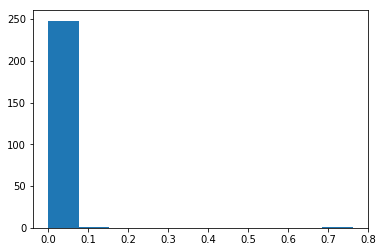



DENVER AP — A proposed $655 million settlement for lowpaid child care workers from around the world would be divided up under a formula after a judge decides whether the agreement is fair a conclusion that could take several months to reach

The deal filed in Denver federal court Wednesday  covers nearly 100000 people mainly women who came to the United States to work as au pairs between Jan 1 2009 and Oct 28 2018 Lawyers who have been representing the au pairs in the classaction case for free over the past four years expect to ask a judge for 35 percent of the settlement for compensation and legal fees leaving about $40 million to be divided among the au pairs

The 11 au pairs named as plaintiffs — from Colombia Australia Germany South Africa and Mexico — would get $5000 each as a base payment Amounts for other au pairs and any additional money for the plaintiffs would be determined using the formula which factors in when they worked whether they had to undergo unpaid training which

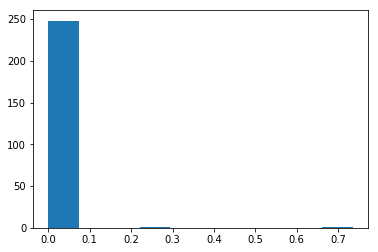



CLOSE Top Democrats say President Donald Trump walked out of a meeting with congressional leaders as talks to end the partial government shutdown remain at an impasse" Jan 9 AP

WASHINGTON  Long before President Donald Trump considered declaring a national emergency to free up money for a wall along the southern border his vice president criticized the idea of the White House making an end run around Congress

Vice President Mike Pence speaking on a Republican Governors Association panel in 2014 attacked the idea of using presidential powers to act unilaterally in the face of congressional opposition

The then governor of Indiana said that "barnstorming around the country defending" such measures was "not leadership" Leadership he argued came with negotiating and finding "common ground"

Pence in his comments was specifically targeting former President Barack Obama a Democrat and the executive orders he announced on Nov 20 2014 one day after the conference

Although the positions wer

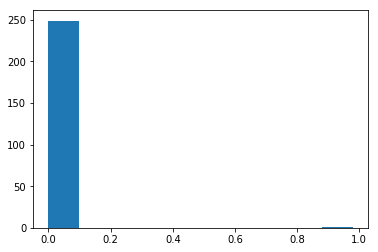



Rudy Giuliani President Trump personal attorney suggested that Trump legal team should have the chance to “correct” special counsel Bob Mueller final report in case it is “wrong”

Giuliani told The Hill on Thursday that the president legal team should be allowed to review and “correct” the report before it is released to Congress

Advertisement

“As a matter of fairness they should show it to you — so we can correct it if theyre wrong” Giuliani told the outlet “Theyre not God after all They could be wrong”

Giuliani said that the legal team must be able to review the report before it is made public in order to protect executive privilege

“Of course we have to see [the report] before it goes to Congress” he said “We have reserved executive privilege and we have a right to assert it The only way we can assert it is if we see what is in the report”

Experts quickly laughed off Giuliani assertion that the president can “correct” an investigative report into his own actions

National sec

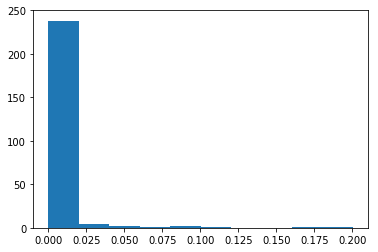



President Trump spoke during a discussion Friday at the White House with state local and community leaders about border security and safe communities

WASHINGTON — President Trump says it would be easy for him just to declare a national emergency and find federal money to build a barrier along the southern border but he not going to be so quick to do that because he thinks lawmakers can do it

Trump spoke during a discussion Friday at the White House with state local and community leaders about border security and safe communities

The president says the easy solution is for me to call a national emergency    but Im not going to do it so fast

Advertisement

Trump says This is something that Congress can do

Attendees included state attorneys general local elected leaders faith leaders and federal state and local law enforcement officials
('wall', 'border', 'mexico', 'emergency', 'national emergency')
('friday', 'pay', 'border', 'wall', 'workers')
('party', 'democratic', 'candidates'

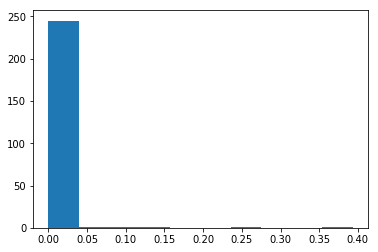



ES News Email Enter your email address Please enter an email address Email address is invalid Fill out this field Email address is invalid You already have an account Please log in or register with your social account

Disappointed families have been offered a refund for a “spectacularly bad” pantomime in Chippenham which some audience members claim included “only three people”

Chippenham Neeld Community and Arts Centre ran Jack and the Beanstalk on three dates over Christmas promising to bring “festive joy” with its “sparkling set and glittering costumes”

However unhappy customers said they were left “mortified” at the show with one suggesting “it felt as if two of the cast members had been pulled in at the last minute and it was their first live show”

Refunds are now being given out to audience members as the town council which runs the venue said in a statement that “this was not the standard of show the Neeld is used to presenting”

While one customer branded the panto which r

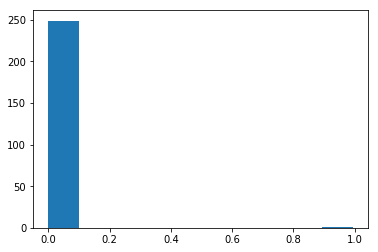



On the twentyfirst day of the partial government shutdown federallyfunded TSA officers came to work at Vermont Burlington International Airport despite facing a painful reality their biweekly paychecks would not arrive

The partial shutdown began on Dec 22 will become the longest in American history on Saturday but Friday marks the first time that TSA agents will miss a regularlyscheduled payday The shutdown is the result of an impasse between President Donald Trump and congressional Democrats over the president $57 billion request to build a wall along the USMexico border and has halted the paychecks of hundreds of thousands of government workers

But TSA agents are still required to show up to work as they are considered essential employees

TSA agents at Burlington International Airport in South Burlington VT await passengers to screen at a security checkpoint on Friday Jan 11 2019 Despite no paychecks going out agents continued to report to work according to airport Federal Secur

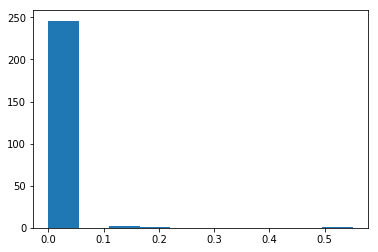



SACRAMENTO Calif — Gov Gavin Newsom held his toddler son during his inaugural address spent nearly two hours discussing his state budget with reporters and engaged in two Twitter spats with the president

Newsom 51 took office Monday and quickly dove into governing the nation most populous state but with a different focus and touch than his 80yearold predecessor fellow Democrat Jerry Brown

Newsom a father of four placed expanding early education and paid leave at the center of a familyfriendly platform he outlined in his inaugural address which delivered a signature image when Newsom 2yearold son Dutch wandered on stage Newsom didnt miss a beat picking up his son and continuing to talk as he cradled him

Three days later when he announced his budget plan Newsom seemed to enjoy his lengthy dialogue with the media and showed a deep grasp of the facts and figures

"Wait til next year youll have to sit here for four hours" he told reporters "I love this stuff"

Brown usually kept the me

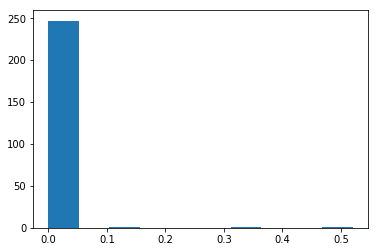



President Donald Trump is getting desperate in his plans to fund the Southern border wall the only solution in his eyes to a “crisis” of illegal immigration along the border The president is considering declaring the border situation national emergency and could possibly take funding away from other national emergencies to build his wall

According to NBC News Trump could take some of the $139 billion of Army Corps funding set aside to help Puerto Rico recover from the deadly and disastrous Hurricane Maria to fund the border wall

Puerto Rico Governor Ricardo Rossello responded to the report on Twitter Friday morning condemning the president for considering taking funds from his home

No wall should be funded on the pain and suffering of US citizens who have endured tragedy and loss through a natural disaster This include those citizens that live in CA TX PR VI and other jurisdictions Today it us tomorrow it could be you — Ricardo Rossello @ricardorossello January 11 2019

Rossello a

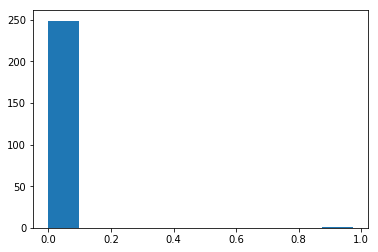



Theyve weathered blistering attacks from the president the exposure of sensitive sources and the politicization of classified information And now theyre not getting paid “Im not going to try to candycoat it” Tom OConnor a special agent and president of the FBI Agents Association told me this week “We really feel that the financial insecurities we are facing right now equates to a national security issue”

On Saturday the current government shutdown will be the longest in US history—and it could remain shuttered for “months or even years” President Donald Trump warned Democrats last week While much of the drama has centered around Trump demand for a wall on the southern border thousands of FBI agents and other federal employees whose unfettered work is crucial to national security have either been furloughed or forced to work with no pay and steep budget cuts

Morale at the FBI had already been steadily declining for months before the government shut down on December 22 according to c

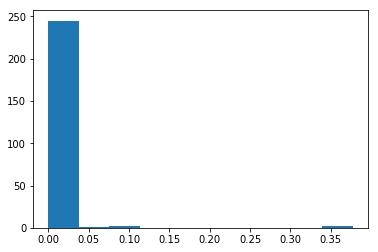

In [53]:
for i in range(10):
    print('\n')
    print(docs[i][:1000])
    for topic in itemgetter(*np.argsort(-lda_vectors[i])[:3])(topic_keywords):
        print(topic)
    plt.hist(lda_vectors[i])
    plt.show()

In [54]:
df_subset['lda_cluster_assignment'] = np.argmax(lda_vectors, axis=1)
# must filter low probs though

In [55]:
# must bring out topic words...
lda_topics = np.random.choice(np.unique(df_subset['lda_cluster_assignment']), 5, replace=False)

n_clusters = []
topics_recalls = {}

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    n_clusters.append(n)
    for topic in lda_topics:
        df_subset['is_topic'] = (df_subset['lda_cluster_assignment'] == topic)

        cluster_supports = df_subset[df_subset.is_topic]['story_cluster_id'].value_counts()
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)
        recall = max_support / total_support

        if topic in topics_recalls:
            topics_recalls[topic].append(recall)
        else:
            topics_recalls[topic] = [recall]    

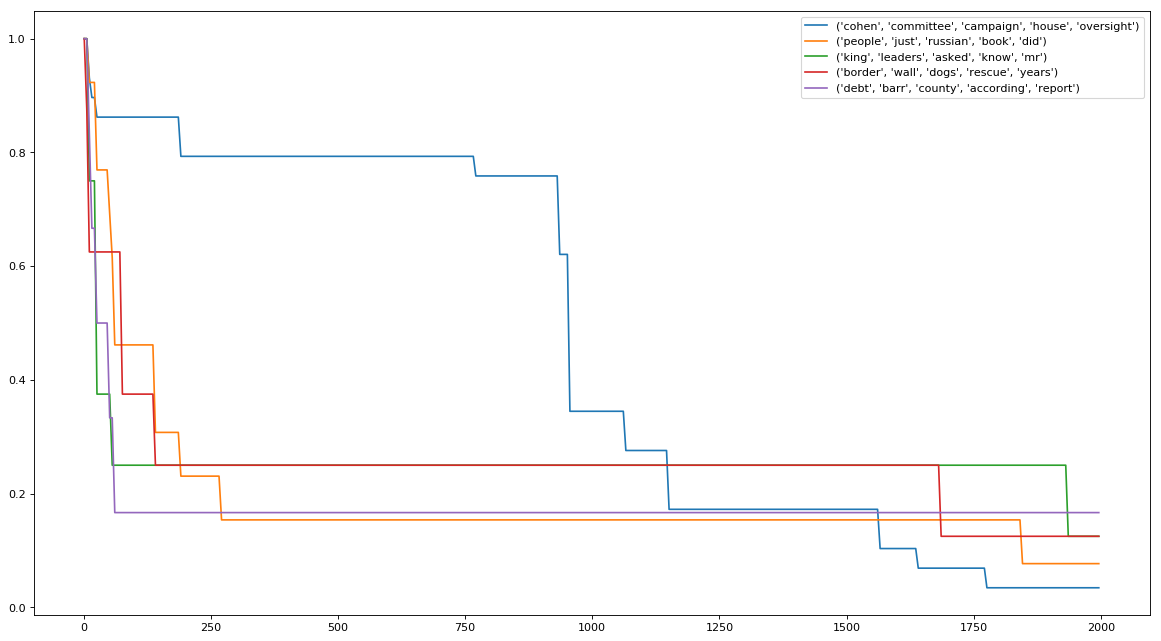

In [56]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
for topic in lda_topics:
    plt.plot(n_clusters, topics_recalls[topic], label=topic_keywords[topic])
plt.legend()
plt.show()

In [57]:
lda_topics = np.unique(df_subset['lda_cluster_assignment'])
n_clusters = []
avg_recalls = []
avg_precisions = []

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    topic_cluster_supports = {}
    for topic in lda_topics:
        df_subset['is_topic'] = (df_subset['lda_cluster_assignment'] == topic)

        cluster_supports = df_subset[df_subset.is_topic]['story_cluster_id'].value_counts()
        max_cluster = cluster_supports.index[0]
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)

        cluster_supports = {cluster:support 
                            for cluster, support 
                            in zip(cluster_supports.index, cluster_supports.values)}
        cluster_supports['max_cluster'] = max_cluster
        cluster_supports['max_support'] = max_support
        cluster_supports['total_support'] = total_support

        topic_cluster_supports[topic] = cluster_supports

    recalls = []
    precisions = []
    for topic in lda_topics:
        cluster_supports = topic_cluster_supports[topic]
        max_cluster = cluster_supports['max_cluster']
        max_support = cluster_supports['max_support']
        total_support = cluster_supports['total_support']

        recall = max_support / total_support
        recalls.append(recall)

        max_cluster_other_kw_articles = np.sum(
            [other_cluster_supports[max_cluster] 
            for other_topic, other_cluster_supports 
            in topic_cluster_supports.items()
            if ((other_topic != topic) and (max_cluster in other_cluster_supports))]
        )
        precision = max_support / (max_support + max_cluster_other_kw_articles)
        precisions.append(precision)
        
    n_clusters.append(n)
    avg_recalls.append(np.mean(recalls))
    avg_precisions.append(np.mean(precisions))
    

In [58]:
n_clusters = np.array(n_clusters)
avg_recalls = np.array(avg_recalls)
avg_precisions = np.array(avg_precisions)

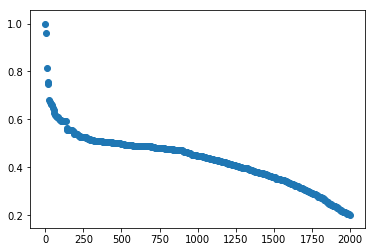

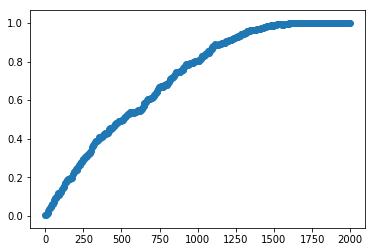

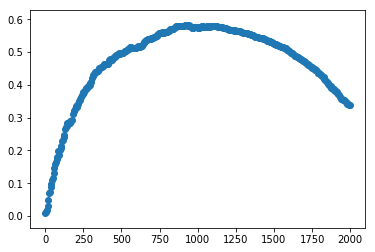

926


In [59]:
# 250
plt.scatter(n_clusters, avg_recalls)
plt.show()

plt.scatter(n_clusters, avg_precisions)
plt.show()

avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)
                                                
plt.scatter(n_clusters, avg_f1s)
plt.show()
print(n_clusters[np.argmax(avg_f1s)])

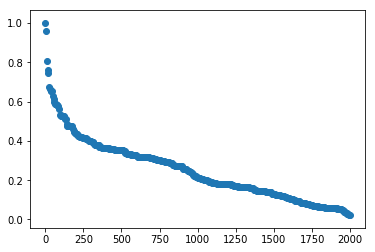

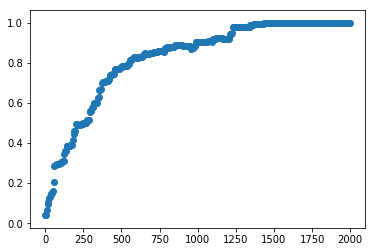

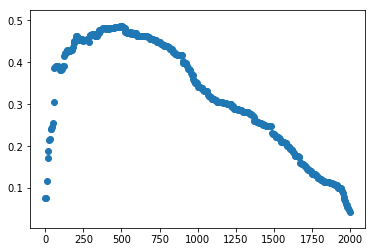

496


In [46]:
# 25
plt.scatter(n_clusters, avg_recalls)
plt.show()

plt.scatter(n_clusters, avg_precisions)
plt.show()

avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)
                                                
plt.scatter(n_clusters, avg_f1s)
plt.show()
print(n_clusters[np.argmax(avg_f1s)])

## Methods for initial keyword selection

In [334]:
nlp = spacy.load('en')

def dedupe_keywords(keywords, token_2_idx, doc_vectors, max_out=25, 
                    must_include_noun=True):
    selected_keywords = []

    for keyword in keywords:
        if len(selected_keywords) > max_out:
            break

        if must_include_noun and not contains_noun(keyword):
            continue

        add_keyword = True
        if selected_keywords:
            for selected_keyword in selected_keywords:
                token_1_id = token_2_idx[keyword]
                token_2_id = token_2_idx[selected_keyword]
                add_keyword = tokens_unrelated(
                    token_1_id,
                    token_2_id,
                    doc_vectors
                )
                if not add_keyword:
                    break

        if add_keyword:
            selected_keywords.append(keyword)
    
    return selected_keywords


def tokens_unrelated(token_1_id, token_2_id, doc_vectors, pmax=0.05):
    token_1_docs = (doc_vectors[:, token_1_id].toarray() > 0)
    token_2_docs = (doc_vectors[:, token_2_id].toarray() > 0)
    
    p_t2_g_t1 = (
        np.sum(token_1_docs & token_2_docs) 
        / np.sum(token_1_docs) 
    )
    
    p_t1_g_t2 = (
        np.sum(token_1_docs & token_2_docs) 
        / np.sum(token_2_docs) 
    )
    
    return ((p_t2_g_t1 < pmax) and (p_t1_g_t2 < pmax))


def contains_noun(txt):
    txt = nlp(txt)
    pos = [token.pos_ for token in txt]
    
    return ('PROPN' in pos or 'NOUN' in pos)

### Rake NLTK

Package: https://pypi.org/project/rake-nltk/

Variables:
- Max support
- Min support
- ngram range
- Keywords ranking metric - doc level
- Keywords per doc
- Keywords ranking metric - corpus level
- must_include_noun
- Tokens unrelated pmax

In [356]:
from rake_nltk import Rake, Metric

In [357]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.5
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [378]:
%%time
KEYWORDS_PER_DOC = 10
MIN_DOC_SUPPORT = 5
keywords_counts = {}
keywords_sums = {}

for doc in docs:
    doc = doc.lower()
    r = Rake(min_length=1, max_length=2, ranking_metric=Metric.WORD_DEGREE, punctuations='.!?,;:()\'’`“"')
    r.extract_keywords_from_text(doc)
    kws = r.get_ranked_phrases_with_scores()
    
    for (score, kw) in kws[:KEYWORDS_PER_DOC]:
        if kw in keywords_counts:
            keywords_counts[kw] += 1
            keywords_sums[kw] += score
        else:
            keywords_counts[kw] = 1
            keywords_sums[kw] = score

CPU times: user 4.09 s, sys: 156 ms, total: 4.24 s
Wall time: 4.3 s


In [379]:
keywords_scores = [(keyword, keywords_sums[keyword]) 
                   for keyword, count 
                   in keywords_counts.items()
                   if (count > MIN_DOC_SUPPORT and keyword in doc_token_2_idx)]
keywords_scores = sorted(keywords_scores, key=lambda x: x[1], reverse=True)

In [380]:
keywords = [keyword for keyword, score in keywords_scores]

dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['border wall',
 'jayme closs',
 'fbi investigation',
 'syria',
 'trump cohen',
 'maduro government',
 '2020 campaign',
 'king open',
 'police officer',
 'men accused',
 'child marriage',
 'mueller team',
 'benefit russia',
 'companies fail']

### Sentence subjects

Variables:
- Max support
- Min support
- ngram range
- must_include_noun
- Tokens unrelated pmax

In [344]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.5
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [345]:
subjects_counts = Counter()
for doc in tqdm_notebook(docs):
    doc = nlp(doc)
    for chunk in doc.noun_chunks:
        if len(chunk) > 1 and chunk.root.dep_ == 'nsubj':
            subjects_counts[chunk.text] += 1

In [346]:
keywords = [subject 
            for subject, count 
            in subjects_counts.most_common(1000)
            if subject in doc_token_2_idx]

dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['federal workers',
 'operational funds',
 'alive authorities',
 'old rivalries',
 'military preparations',
 'federal prosecutors',
 'white supremacy',
 'state workers',
 'counterintelligence agents',
 'list prices']

### Sentence objects

Variables:
- Max support
- Min support
- ngram range
- must_include_noun
- Tokens unrelated pmax

In [347]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.5
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [348]:
subjects_counts = Counter()
for doc in tqdm_notebook(docs):
    doc = nlp(doc)
    for chunk in doc.noun_chunks:
        if len(chunk) > 1 and chunk.root.dep_ == 'dobj':
            subjects_counts[chunk.text] += 1

In [349]:
keywords = [subject 
            for subject, count 
            in subjects_counts.most_common(1000)
            if subject in doc_token_2_idx]

dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['emergency powers',
 'polling data',
 'drug prices',
 'temper tantrums',
 'numerous searches',
 'oral arguments',
 'liberal priorities',
 'chemical weapons',
 'older spouses',
 'false statements',
 'uncharted territory',
 'tear gas',
 'large swaths',
 'posthumous pardons',
 'public safety',
 'better leadership',
 'heavy criticism',
 'continued use',
 'personal riches',
 'religious liberty',
 'global attention',
 'diplomatic ties',
 'additional information',
 'similar laws']

### Texts bigrams

Variables:
- Max support
- Min support
- ngram range
- must_include_noun
- Tokens unrelated pmax

In [350]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(2, 2), stop_words='english', min_df=5, max_df = 0.5
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = tfidf_vectorizer.fit_transform(docs)
doc_idx_2_token = tfidf_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [351]:
args = np.array(np.argsort(-np.sum(doc_vectors, axis=0)))[0]

keywords = []
for arg in tqdm_notebook(args):
    token = doc_idx_2_token[arg]
    if contains_noun(token):
        keywords += [token]

In [352]:
dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['donald trump',
 'county sheriff',
 'high court',
 'st louis',
 'training ground',
 'sexual abuse',
 'county gop',
 'gay people',
 'mr king',
 'flu season',
 'el chapo',
 'local governments',
 'told newspaper',
 'mcmanus said',
 'prosecutor office',
 'drunk driving',
 'marriage legal',
 'number individuals',
 'additional funding',
 'gaza city',
 'sustained injuries',
 'trade association',
 'city police',
 'diplomats britain',
 'oppositionrun congress',
 'statement look']

### Titles bigrams

Variables:
- Max support
- Min support
- ngram range
- must_include_noun
- Tokens unrelated pmax

In [353]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(2, 2), stop_words='english', min_df=5, max_df = 0.5
)
titles = list(df_subset['title'].apply(clean))
title_vectors = tfidf_vectorizer.fit_transform(titles)
title_idx_2_token = tfidf_vectorizer.get_feature_names()
title_token_2_idx = {token:idx for idx, token in enumerate(title_idx_2_token)}

In [354]:
args = np.array(np.argsort(-np.sum(title_vectors, axis=0)))[0]

keywords = []
for arg in tqdm_notebook(args):
    token = title_idx_2_token[arg]
    if contains_noun(token):
        keywords += [token]

In [355]:
dedupe_keywords(
    keywords, 
    title_token_2_idx, 
    title_vectors, 
    max_out=25, 
    must_include_noun=True
)

['government shutdown',
 'steve king',
 'national emergency',
 'jayme closs',
 'michael cohen',
 'middle east',
 'supreme court',
 'jim acosta',
 'police officer',
 'emergency powers',
 'beto orourke',
 'bernie sanders',
 'new term',
 'florida governor',
 'running president',
 'govt shutdown',
 'withdrawal syria',
 'bangkok post',
 'run president',
 'drug prices',
 'declare emergency',
 'fbi investigated',
 'trump shutdown',
 'saudi teen',
 'equipment syria',
 'pay wall']

### Bayesian bigrams

From here: https://www.agiliq.com/blog/2009/03/finding-keywords-using-python/

Variables:
- ngram range
- must_include_noun
- Tokens unrelated pmax

In [312]:
count_vectorizer = CountVectorizer(
    ngram_range=(2, 2), stop_words='english'
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [313]:
total_tokens = np.sum(doc_vectors)
total_tokens

617660

In [314]:
doc_idx_2_prob = (np.array(np.sum(doc_vectors, axis=0))[0]/total_tokens)

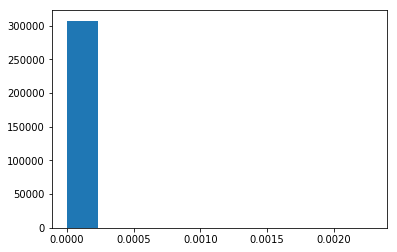

In [315]:
plt.hist(doc_idx_2_prob)
plt.show()

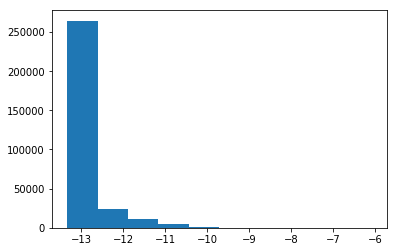

In [316]:
plt.hist(np.log(doc_idx_2_prob))
plt.show()

In [317]:
%%time
doc_token_2_prob = {token:doc_idx_2_prob[idx]
                    for idx, token 
                    in enumerate(doc_idx_2_token)}

CPU times: user 209 ms, sys: 22.9 ms, total: 232 ms
Wall time: 122 ms


In [318]:
def find_keywords(text, count_vectorizer, token_probs, max_keywords=10):
    vector = count_vectorizer.fit_transform([text]).toarray()[0]
    vector = vector/np.sum(vector)
    tokens = count_vectorizer.get_feature_names()
    
    token_scores = [(token, freq * -np.log(token_probs[token])) 
                   for token, freq 
                   in zip(tokens, vector)]
    
    token_scores = sorted(token_scores, key=lambda x: x[1], reverse=True)
    
    return token_scores[:max_keywords]

In [319]:
%%time
KEYWORDS_PER_DOC = 10
MIN_DOC_SUPPORT = 5
keywords_counts = {}
keywords_sums = {}

for doc in tqdm_notebook(docs):
    kws = find_keywords(text=doc, 
                        count_vectorizer=count_vectorizer, 
                        token_probs=doc_token_2_prob,
                        max_keywords=KEYWORDS_PER_DOC)
    
    for (kw, score) in kws:
        if kw in keywords_counts:
            keywords_counts[kw] += 1
            keywords_sums[kw] += score
        else:
            keywords_counts[kw] = 1
            keywords_sums[kw] = score

CPU times: user 5 s, sys: 79 ms, total: 5.08 s
Wall time: 5.04 s


In [320]:
keywords_scores = [(keyword, keywords_sums[keyword]) 
                   for keyword, count 
                   in keywords_counts.items()
                   if (count > MIN_DOC_SUPPORT and keyword in doc_token_2_idx)]
keywords_scores = sorted(keywords_scores, key=lambda x: x[1], reverse=True)

In [321]:
keywords = [keyword for keyword, score in keywords_scores]

dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['national emergency',
 'jayme closs',
 'tarrant county',
 'broward county',
 'sexual harassment',
 'cohen said',
 'davis police',
 'security advisor',
 'according source',
 'lake county',
 'abu dhabi',
 'forced marriage',
 'tent city',
 'clearance investigation']

### Textrank

In [265]:
from summa import keywords
from summa.summarizer import summarize

In [266]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.25
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [268]:
%%time
KEYWORDS_PER_DOC = 10
MIN_DOC_SUPPORT = 5
keywords_counts = {}

for doc in tqdm_notebook(docs):
    kws = keywords.keywords(doc).split('\n')
    
    for kw in kws:
        if kw in keywords_counts:
            keywords_counts[kw] += 1
        else:
            keywords_counts[kw] = 1

CPU times: user 2min 39s, sys: 13.2 s, total: 2min 52s
Wall time: 2min 30s


In [269]:
keywords_scores = [(keyword, count) 
                   for keyword, count 
                   in keywords_counts.items()
                   if (count > MIN_DOC_SUPPORT and keyword in doc_token_2_idx)]
keywords_scores = sorted(keywords_scores, key=lambda x: x[1], reverse=True)

In [271]:
keywords = [keyword for keyword, score in keywords_scores]

dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

['times',
 'holland',
 'halffull',
 'daca',
 'clearance',
 'venezuelans',
 'pricing',
 'highprofile candidates',
 'pam',
 'secures']

## Assign Story Clusters

In [381]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=5, max_df = 0.5
)
docs = list(df_subset['text'].apply(clean))
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

In [382]:
%%time
KEYWORDS_PER_DOC = 10
MIN_DOC_SUPPORT = 5
keywords_counts = {}
keywords_sums = {}

for doc in docs:
    doc = doc.lower()
    r = Rake(min_length=1, max_length=2, ranking_metric=Metric.WORD_DEGREE, punctuations='.!?,;:()\'’`“"')
    r.extract_keywords_from_text(doc)
    kws = r.get_ranked_phrases_with_scores()
    
    for (score, kw) in kws[:KEYWORDS_PER_DOC]:
        if kw in keywords_counts:
            keywords_counts[kw] += 1
            keywords_sums[kw] += score
        else:
            keywords_counts[kw] = 1
            keywords_sums[kw] = score

CPU times: user 3.79 s, sys: 143 ms, total: 3.93 s
Wall time: 3.98 s


In [383]:
keywords_scores = [(keyword, keywords_sums[keyword]) 
                   for keyword, count 
                   in keywords_counts.items()
                   if (count > MIN_DOC_SUPPORT and keyword in doc_token_2_idx)]
keywords_scores = sorted(keywords_scores, key=lambda x: x[1], reverse=True)

In [384]:
keywords = [keyword for keyword, score in keywords_scores]

keywords = dedupe_keywords(
    keywords, 
    doc_token_2_idx, 
    doc_vectors, 
    max_out=25, 
    must_include_noun=True
)

In [387]:
n_clusters = []
keywords_recalls = {}
avg_recalls = []
keywords_precisions = {}
avg_precisions = []

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    keyword_cluster_supports = {}
    for keyword in keywords:
        idx = doc_token_2_idx[keyword]
        df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

        cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
        max_cluster = cluster_supports.index[0]
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)

        cluster_supports = {cluster:support 
                            for cluster, support 
                            in zip(cluster_supports.index, cluster_supports.values)}
        cluster_supports['max_cluster'] = max_cluster
        cluster_supports['max_support'] = max_support
        cluster_supports['total_support'] = total_support

        keyword_cluster_supports[keyword] = cluster_supports

    recalls = []
    precisions = []
    for keyword in keywords:
        cluster_supports = keyword_cluster_supports[keyword]
        max_cluster = cluster_supports['max_cluster']
        max_support = cluster_supports['max_support']
        total_support = cluster_supports['total_support']

        recall = max_support / total_support
        
        if keyword in keywords_recalls:
            keywords_recalls[keyword].append(recall)
        else:
            keywords_recalls[keyword] = [recall]
        
        recalls.append(recall)

        max_cluster_other_kw_articles = np.sum(
            [other_cluster_supports[max_cluster] 
            for other_keyword, other_cluster_supports 
            in keyword_cluster_supports.items()
            if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
        )
        precision = max_support / (max_support + max_cluster_other_kw_articles)
        if keyword in keywords_precisions:
            keywords_precisions[keyword].append(precision)
        else:
            keywords_precisions[keyword] = [precision]
        precisions.append(precision)
        
    n_clusters.append(n)
    avg_recalls.append(np.mean(recalls))
    avg_precisions.append(np.mean(precisions))
    

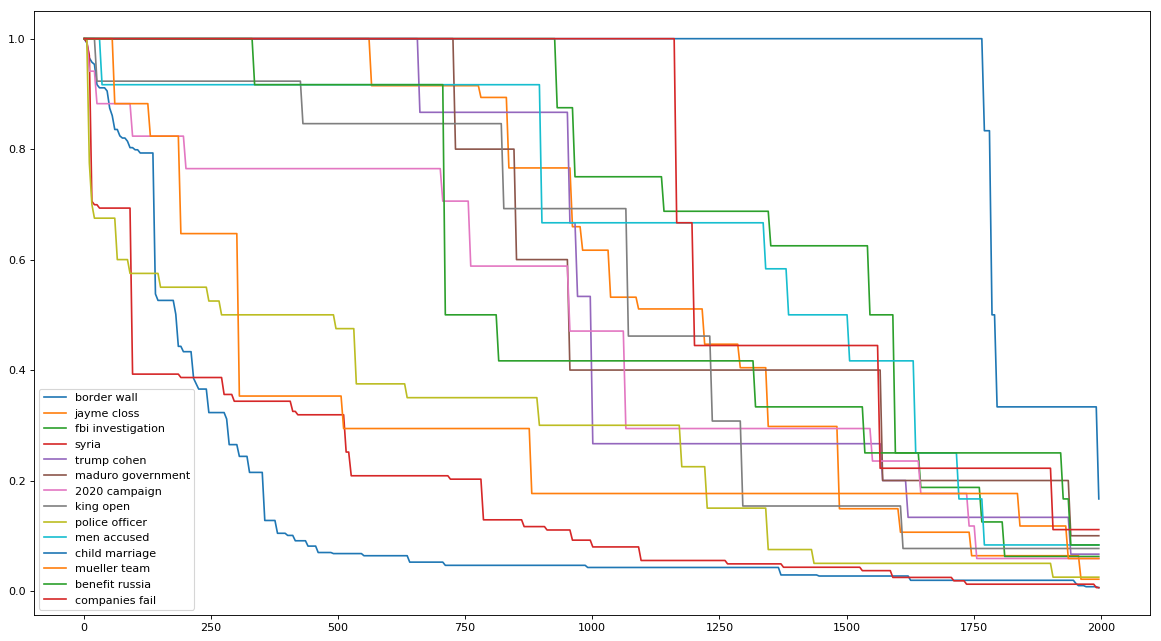

In [389]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
for keyword in keywords:
    plt.plot(n_clusters, keywords_recalls[keyword], label=keyword) 
plt.legend()
plt.show()

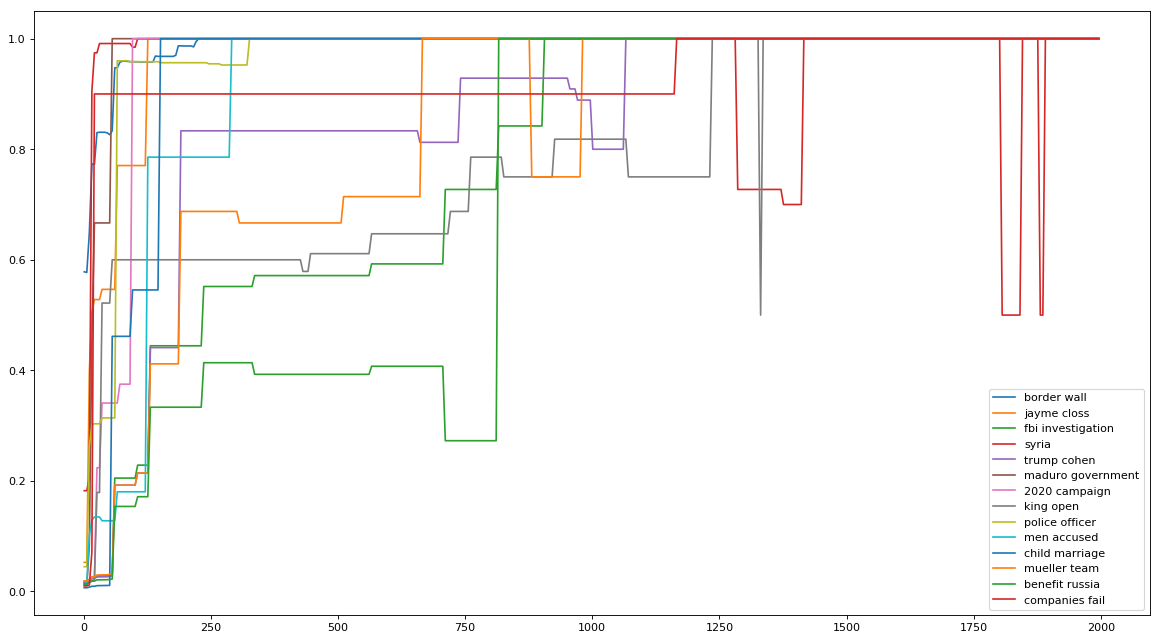

In [390]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
for keyword in keywords:
    plt.plot(n_clusters, keywords_precisions[keyword], label=keyword) 
plt.legend()
plt.show()

In [391]:
n_clusters = np.array(n_clusters)
avg_recalls = np.array(avg_recalls)
avg_precisions = np.array(avg_precisions)

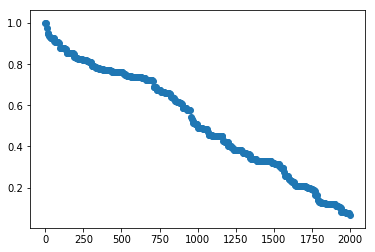

In [392]:
plt.scatter(n_clusters, avg_recalls)
plt.show()

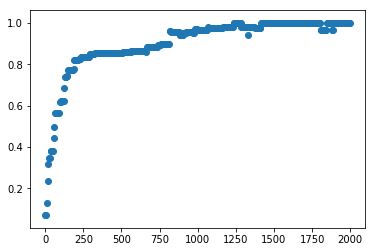

In [393]:
plt.scatter(n_clusters, avg_precisions)
plt.show()

In [394]:
avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)

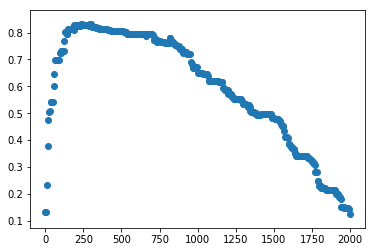

In [395]:
plt.scatter(n_clusters, avg_f1s)
plt.show()

In [396]:
optimal_n_clusters = n_clusters[np.argmax(avg_f1s)]
optimal_n_clusters

291

In [397]:
df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, optimal_n_clusters)

In [398]:
story_cluster_id_counts = df_subset['story_cluster_id'].value_counts()

In [399]:
story_cluster_id_counts

3694    168
3682    120
3705     69
3569     59
3434     48
3668     47
3691     40
3506     37
3696     36
3649     30
3675     28
3623     28
3561     28
3542     27
3613     25
3316     25
3624     24
3345     24
3687     24
3698     22
3697     20
3101     20
3456     19
3433     18
3019     17
3565     17
3642     16
3672     16
3704     16
3695     16
       ... 
3432      2
3273      2
120       1
1714      1
1287      1
1069      1
1744      1
1052      1
1145      1
1822      1
79        1
1843      1
1027      1
708       1
1615      1
1022      1
1231      1
1063      1
264       1
919       1
273       1
914       1
282       1
292       1
464       1
837       1
1382      1
759       1
629       1
1386      1
Name: story_cluster_id, Length: 291, dtype: int64

In [400]:
iterations = 0 
for idx, ct in zip(story_cluster_id_counts.index, story_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = df_subset[
            df_subset['story_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




168 articles in cluster 3694
HEADLINE: Trump not ready to declare emergency over wall
HEADLINE: Republican Senator Graham: Trump should use emergency powers to fund wall
HEADLINE: Trump threatens emergency declaration ahead of border visit
HEADLINE: Trump: 'We're Not Changing Our Mind' on Border Wall
HEADLINE: Trump holds off on declaring emergency to build border wall
HEADLINE: Trump asks how many Pakistanis apprehended at border
HEADLINE: Government shutdown news: Trump will not declare national emergency 'right now' as Pelosi says he must make next move over impasse
HEADLINE: Trump edges closer to declaring national emergency to fund border wall
HEADLINE: A lot of Republicans are worried about the dangerous precedent Trump could set with a national emergency declaration for the border wall
HEADLINE: Will Donald Trump Face Legal Challenges if He Declares a National Emergency Over the Border Wall?
HEADLINE: President Trump Went to a Border Town to Prove They Need a Wall. Residents 

## Substory Clustering

In [ ]:
story_filt = (df_subset['story_cluster_id'] == story_cluster_id_counts.index[2])
story_indices = np.where(story_filt)[0]
story_subset = df_subset[story_filt].reset_index().drop(['index'], axis=1)
story_doc_vectors = doc_vectors[story_indices, :]
story_n_articles = len(story_subset)

In [ ]:
%%time
WORDS_TO_CONSIDER = 100
story_docs = list(story_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:WORDS_TO_CONSIDER])))
story_doc_vectors, _ = vectorize(story_docs, tfidf=True)

In [ ]:
%%time
substory_ac_result = agglomerative_cluster(
    story_doc_vectors.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)
substory_ac_result_dec = substory_ac_result[::-1] # easier to work with

In [ ]:
substory_ac_result_dec.shape

In [ ]:
x_max = story_n_articles//2
plt.scatter(np.arange(story_n_articles-1), substory_ac_result_dec[:, 2])
plt.axvline(story_n_articles//20)
plt.axvline(story_n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
plt.xlim(0, x_max)
plt.ylim(min(substory_ac_result_dec[:x_max, 2]), max(substory_ac_result_dec[:x_max, 2]))
plt.show()
plt.close()

In [ ]:
rlng_n = 10
rlng_avg_dists = [np.mean(substory_ac_result_dec[idx:idx+rlng_n, 2]) for idx in np.arange(story_n_articles-rlng_n)]

In [ ]:
dists_slope = [rlng_avg_dists[idx] - rlng_avg_dists[idx+1] for idx in np.arange(len(rlng_avg_dists)-1)]

In [ ]:
plt.scatter(np.arange(len(dists_slope)), dists_slope)
plt.axvline(story_n_articles//20)
plt.axvline(story_n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
plt.xlim(0, x_max)
plt.ylim(min(dists_slope[:x_max]), max(dists_slope[:x_max]))
plt.show()
plt.close()

In [ ]:
story_n_clusters = story_n_articles//50 + np.argmin(dists_slope[story_n_articles//50:story_n_articles//5])
story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, story_n_clusters)

In [ ]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()
substory_cluster_id_counts

In [ ]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')

# LDA

In [ ]:
import re
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import spacy

stop_words = stopwords.words('english')

## Load data

In [ ]:
%%time
# Convert to list
docs = df_subset.text.values.tolist()

# Remove new line characters
docs = [re.sub('\s+', ' ', doc) for doc in docs]

# Remove distracting single quotes
docs = [re.sub("\'", "", doc) for doc in docs]

## Tokenize words, clean up text

In [ ]:
%%time
def doc_to_words(docs):
    for doc in docs:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations

docs_words = list(doc_to_words(docs))

## Create bigram and trigram models

In [ ]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[docs_words[0]]])

## Remove stop words, create bigrams, lemmatize

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(docs):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]

def make_bigrams(docs):
    return [bigram_mod[doc] for doc in docs]

def make_trigrams(docs):
    return [trigram_mod[bigram_mod[doc]] for doc in docs]

def lemmatization(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    docs_out = []
    for doc in docs:
        doc = nlp(" ".join(doc))
        docs_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return docs_out

In [ ]:
%%time
# Remove Stop Words
docs_words_nostops = remove_stopwords(docs_words)

In [ ]:
%%time
# Form Bigrams
docs_words_bigrams = make_bigrams(docs_words_nostops)

In [ ]:
%%time
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
%%time
docs_lemmatized = lemmatization(docs_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(docs_lemmatized[:1])

## Create dictionary and corpus for topic modeling

In [ ]:
%%time

# Create Dictionary
id2word = corpora.Dictionary(docs_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in docs_lemmatized]

# View
print(corpus[:1])

# Build topic model

In [ ]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [ ]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Choose optimal number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list = []
    coherence_values = []
    perplexity_values = []
    for num_topics in tqdm_notebook(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)
        perplexity_values.append(model.log_perplexity(corpus))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, perplexity_values

In [ ]:
%%time
start=10; limit=200; step=10;
model_list, coherence_values, perplexity_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=docs_lemmatized, 
    start=start, 
    limit=limit, 
    step=step
)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[np.argmax(coherence_values)]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

## Assign docs to topics 

In [ ]:
def docs_to_topics(lda_model, corpus, docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(docs)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords', 'text']
    return sent_topics_df

In [ ]:
%%time
df_docs_topics_keywords = docs_to_topics(lda_model=optimal_model, corpus=corpus, docs=docs)

In [ ]:
df_docs_topics_keywords.head(10)

In [ ]:
df_subset['story_cluster_id'] = df_docs_topics_keywords['dominant_topic']

In [ ]:
story_cluster_id_counts = df_subset['story_cluster_id'].value_counts()

In [ ]:
story_cluster_id_counts

In [ ]:
iterations = 0 
for idx, ct in zip(story_cluster_id_counts.index, story_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = df_subset[
            df_subset['story_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')

In [ ]:
wp = optimal_model.show_topic(5)
topic_keywords = ", ".join([word for word, prop in wp])
print(topic_keywords)